In [1]:
# 모델 임포트

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate
from keras.utils import to_categorical
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats

In [3]:
# 오류 검출 및 제거

file = open('/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1_raw.txt')
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

# 281873~281875번 line이 공백임

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [4]:
columns = ['user', 'activity', 'time', 'x', 'y', 'z']
df = pd.DataFrame(data = processedList, columns = columns)
df.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [5]:
df.shape

(343416, 6)

In [6]:
df.isnull().sum() # 결측치 체크

,0
user,0
activity,0
time,0
x,0
y,0
z,0


In [7]:
df['activity'].value_counts() # 데이터 분포 확인

,count
activity,
Walking,137375
Jogging,129392
Upstairs,35137
Downstairs,33358
Sitting,4599
Standing,3555


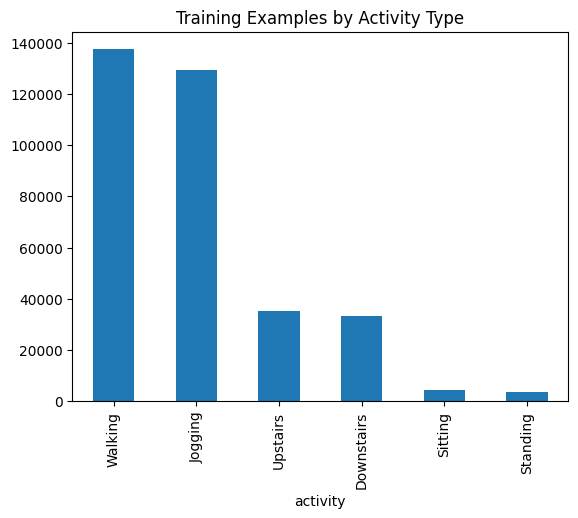

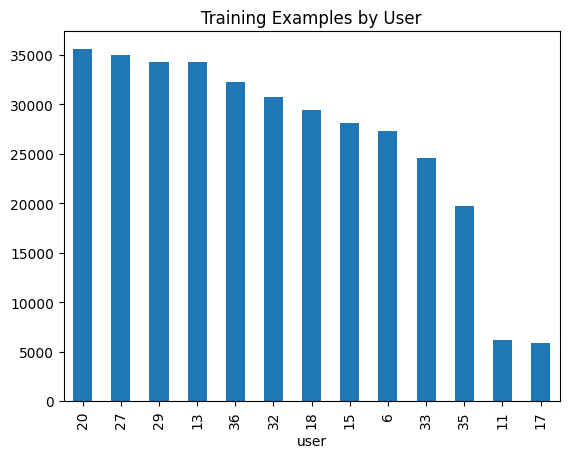

In [8]:
# 데이터 분포 시각화

# Show how many training examples exist for each of the six activities
df["activity"].value_counts().plot(kind = "bar", title = "Training Examples by Activity Type")
plt.show()
# Better understand how the recordings are spread across the different users who participated in the study
df["user"].value_counts().plot(kind = "bar", title = "Training Examples by User")
plt.show()

In [9]:
# float 타입으로 형변환

df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float')

In [10]:
activities = df['activity'].value_counts().index

In [11]:
label = LabelEncoder()
df['activity'] = label.fit_transform(df['activity'])
df.head()

,user,activity,time,x,y,z
0,33,1,49105962326000,-0.694638,12.680544,0.503953
1,33,1,49106062271000,5.012288,11.264028,0.953424
2,33,1,49106112167000,4.903325,10.882658,-0.081722
3,33,1,49106222305000,-0.612916,18.496431,3.023717
4,33,1,49106332290000,-1.184970,12.108489,7.205164


In [12]:
activities

Index(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'], dtype='object', name='activity')

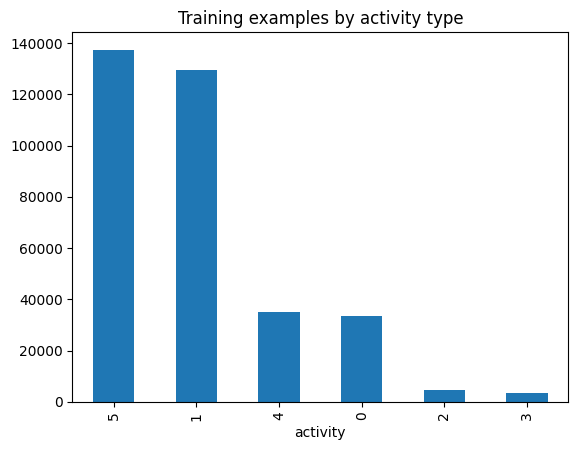

In [13]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [14]:
num_classes = 6 # activity 개수

In [15]:
from sklearn import preprocessing

# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["activity"].values.ravel())

In [16]:
X = df[['x', 'y', 'z']]
y = df['ActivityEncoded']

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X

,x,y,z,label
0,-0.258214,0.697059,0.044419,1
1,0.607502,0.483225,0.145310,1
2,0.590972,0.425654,-0.087046,1
3,-0.245817,1.575011,0.610023,1
4,-0.332596,0.610703,1.548620,1
...,...,...,...,...
343411,-0.105815,0.402609,-0.059530,5
343412,0.265839,0.435820,0.120852,5
343413,-0.031484,0.315054,0.230915,5
343414,-0.391003,0.094656,0.249259,5


In [18]:
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

In [19]:
# 이해가 필요한 부분
##########################################################################################

_size = Fs*4 # 프레임의 길이
hop_size = Fs*2 # 프레임 간 이동 간격
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3 # 특징 개수(x, y, z)

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]

        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size], keepdims = True).mode[0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

##########################################################################################

In [20]:
X, y = get_frames(scaled_X, frame_size, hop_size)


In [21]:
X.shape, y.shape

((8584, 80, 3), (8584,))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [23]:
X_train.shape, X_test.shape

((6867, 80, 3), (1717, 80, 3))

In [24]:
X_train[0].shape, X_test[0].shape

((80, 3), (80, 3))

In [25]:
X_train = X_train.reshape(6867, 80, 3, 1)
X_test = X_test.reshape(1717, 80, 3, 1)

In [26]:
X_train[0].shape, X_test[0].shape

((80, 3, 1), (80, 3, 1))

In [27]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [28]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 79, 2, 16)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 79, 2, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 78, 1, 32)      │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 78, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2496)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       159,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,358 (634.21 KB)

 Trainable params: 162,358 (634.21 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_test, y_test), verbose=1)


Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.5850 - loss: 1.0138 - val_accuracy: 0.8101 - val_loss: 0.5301
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8035 - loss: 0.5581 - val_accuracy: 0.8393 - val_loss: 0.4255
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8341 - loss: 0.4294 - val_accuracy: 0.8532 - val_loss: 0.3667
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8518 - loss: 0.3764 - val_accuracy: 0.8765 - val_loss: 0.3202
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8770 - loss: 0.3115 - val_accuracy: 0.9056 - val_loss: 0.2765
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8930 - loss: 0.2836 - val_accuracy: 0.9109 - val_loss: 0.2682
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9055 - loss: 0.2618 - val_accuracy: 0.9190 - val_loss: 0.2376
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9233 - loss: 0.2040 - val_accuracy: 

In [31]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

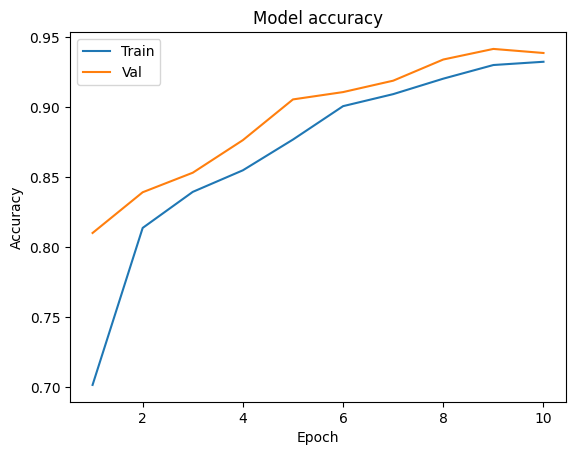

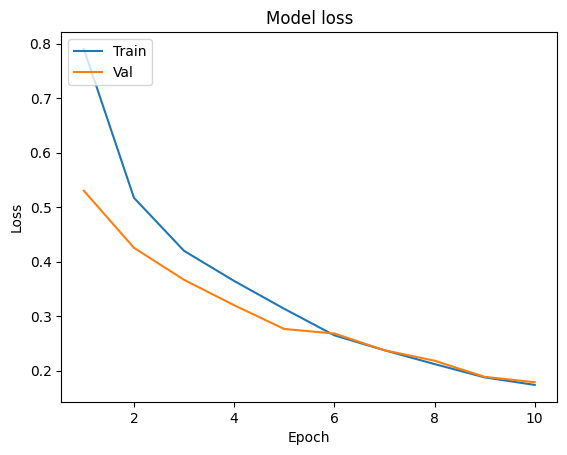

In [32]:
plot_learningCurve(history, 10)

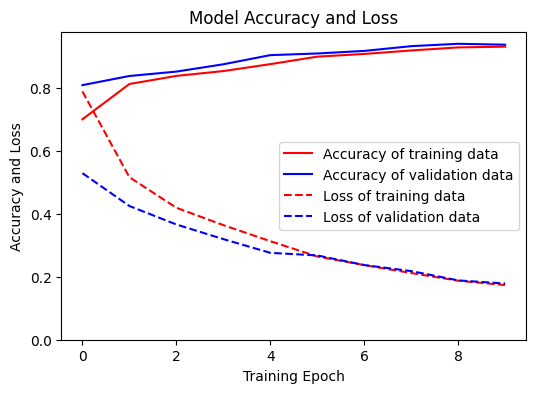

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       667
           1       1.00      0.99      1.00      2586
           2       1.00      1.00      1.00        91
           3       0.99      0.99      0.99        72
           4       0.89      0.97      0.93       702
           5       1.00      0.99      0.99      2749

    accuracy                           0.98      6867
   macro avg       0.97      0.97      0.97      6867
weighted avg       0.98      0.98      0.98      6867



In [33]:
from sklearn.metrics import classification_report

plt.figure(figsize=(6, 4))
plt.plot(history.history["accuracy"], 'r', label = "Accuracy of training data")
plt.plot(history.history["val_accuracy"], 'b', label = "Accuracy of validation data")
plt.plot(history.history["loss"], 'r--', label = "Loss of training data")
plt.plot(history.history["val_loss"], 'b--', label = "Loss of validation data")
plt.title("Model Accuracy and Loss")
plt.ylabel("Accuracy and Loss")
plt.xlabel("Training Epoch")
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model.predict(X_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis = 1)
print(classification_report(y_train, max_y_pred_train))

In [34]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [35]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

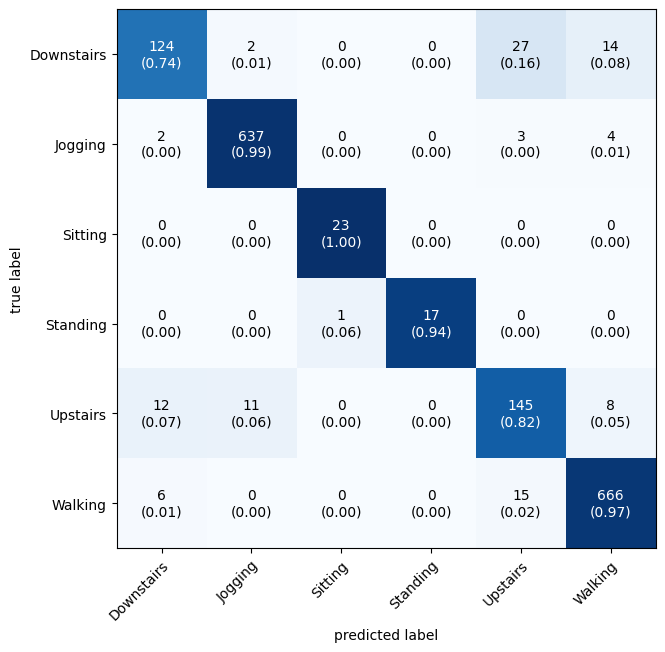

In [36]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))